In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt



In [ ]:
class GaussianMixtureDataset(Dataset):
    def __init__(self, n_samples=10000, centers=8, radius=2.0, std=0.05):
        super().__init__()
        samples = []
        for _ in range(n_samples):
            angle = np.random.randint(0, centers) * 2 * np.pi / centers
            center = np.array([radius * np.cos(angle), radius * np.sin(angle)])
            point = center + np.random.randn(2) * std
            samples.append(point)
        self.samples = torch.from_numpy(np.array(samples, dtype=np.float32))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

dataset = GaussianMixtureDataset(n_samples=10000)
loader = DataLoader(dataset, batch_size=512, shuffle=True)

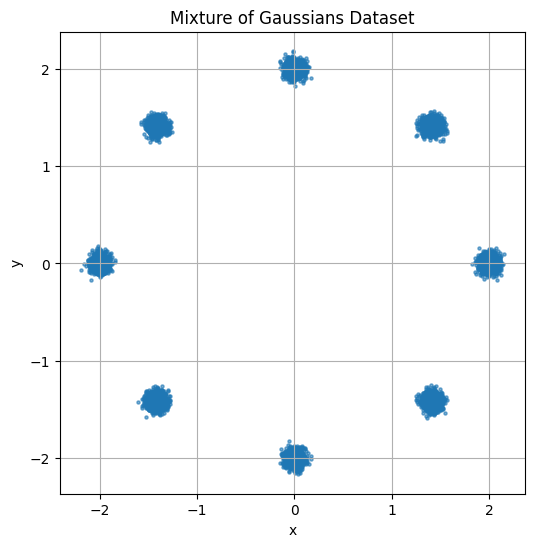

In [ ]:
data = dataset[:].numpy()  

plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], s=5, alpha=0.6)
plt.title("Mixture of Gaussians Dataset")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.show()

In [4]:
class MLP_G(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 2))
    
    def forward(self, z):
        return self.net(z)

class MLP_D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 1))
    
    def forward(self, x):
        return self.net(x)

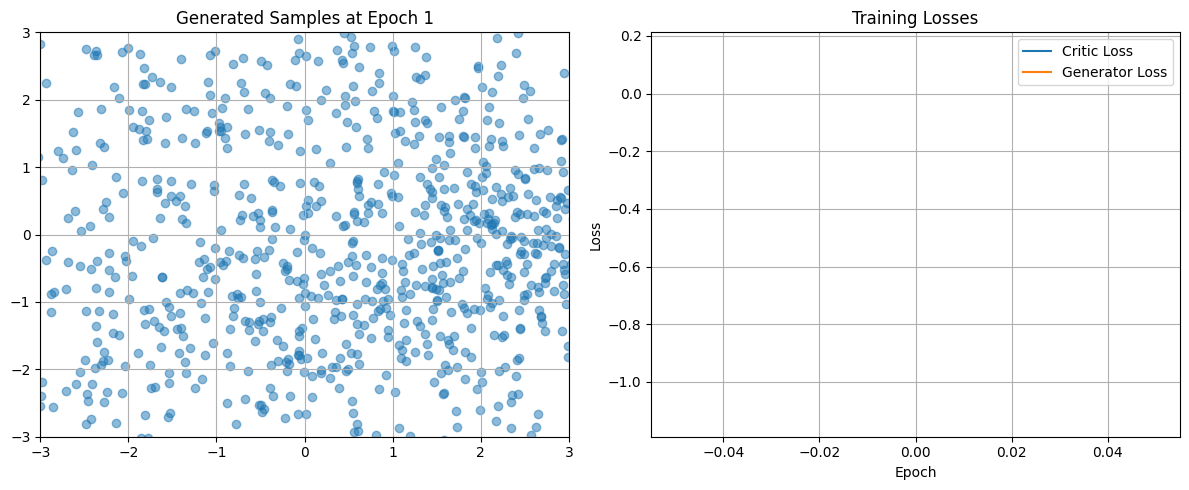

Epoch 0050/1000 | D Loss: -0.4766 | G Loss: 1.3055
Epoch 0100/1000 | D Loss: -0.3076 | G Loss: 0.7660


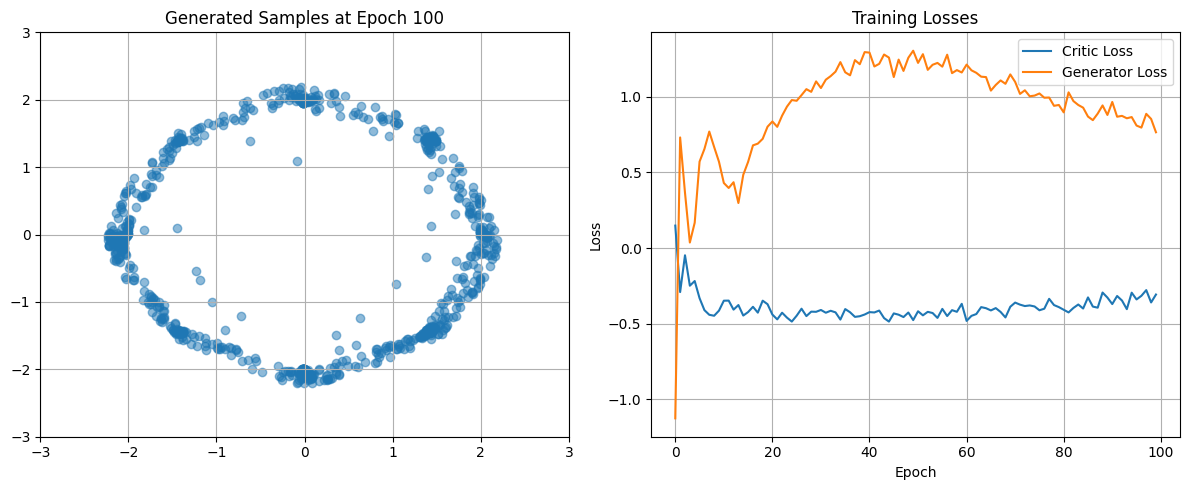

Epoch 0150/1000 | D Loss: -0.2614 | G Loss: 0.5915
Epoch 0200/1000 | D Loss: -0.2519 | G Loss: 0.6163


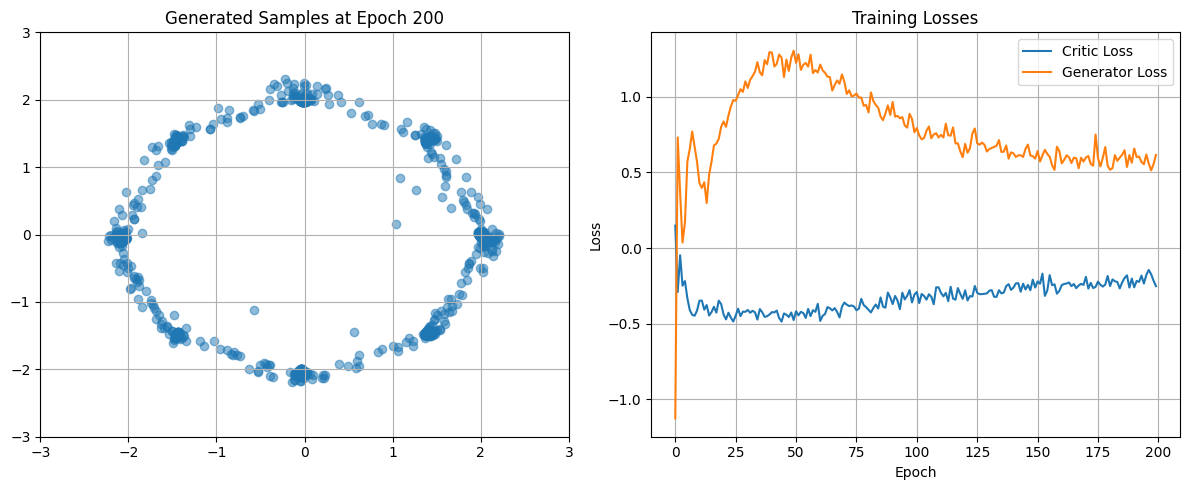

Epoch 0250/1000 | D Loss: -0.1553 | G Loss: 0.5278
Epoch 0300/1000 | D Loss: -0.1620 | G Loss: 0.4160


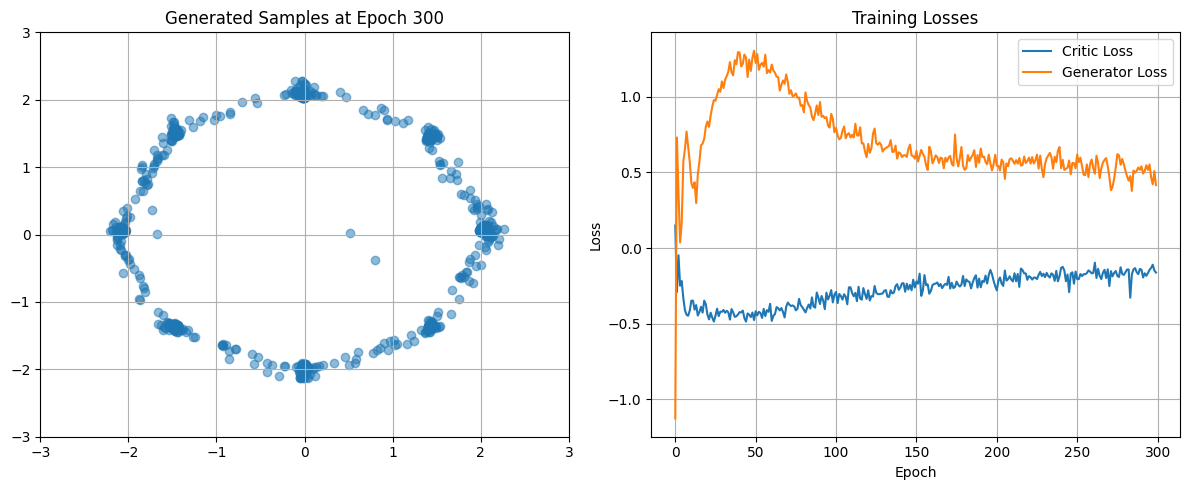

Epoch 0350/1000 | D Loss: -0.1535 | G Loss: 0.6027
Epoch 0400/1000 | D Loss: -0.1113 | G Loss: 0.6788


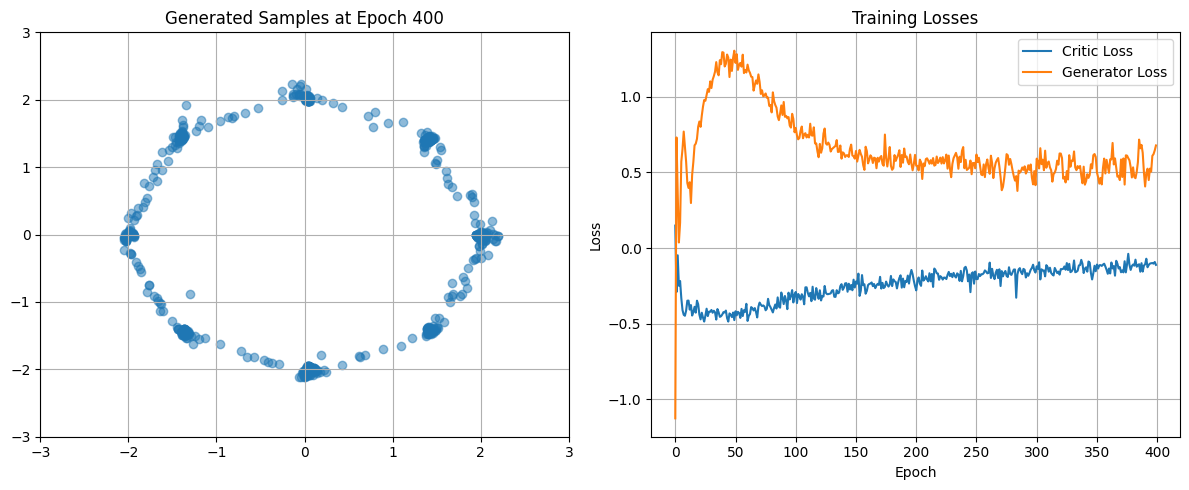

Epoch 0450/1000 | D Loss: -0.0761 | G Loss: 0.7880
Epoch 0500/1000 | D Loss: -0.1143 | G Loss: 0.8144


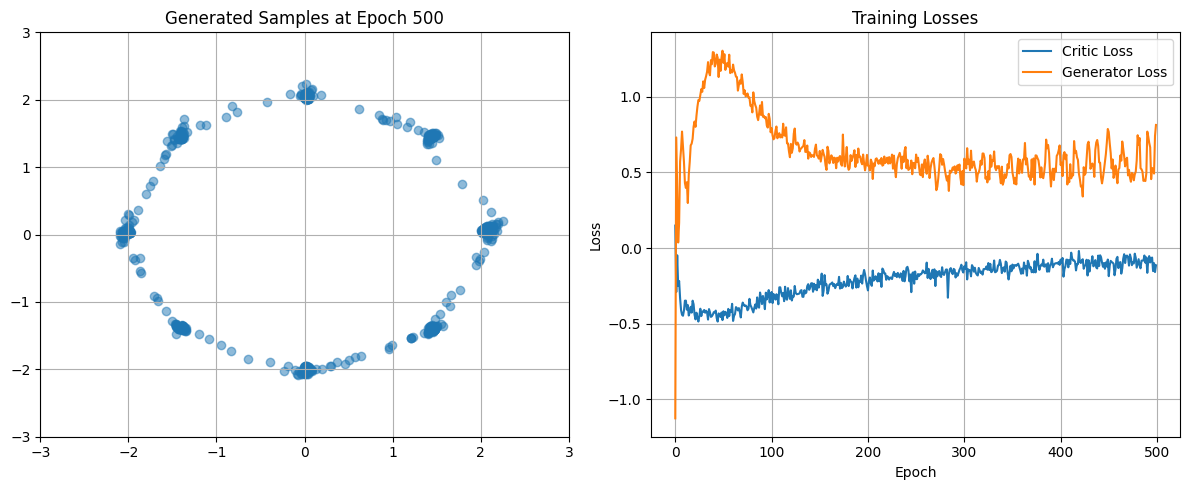

Epoch 0550/1000 | D Loss: -0.0456 | G Loss: 0.7011
Epoch 0600/1000 | D Loss: -0.0288 | G Loss: 0.3742


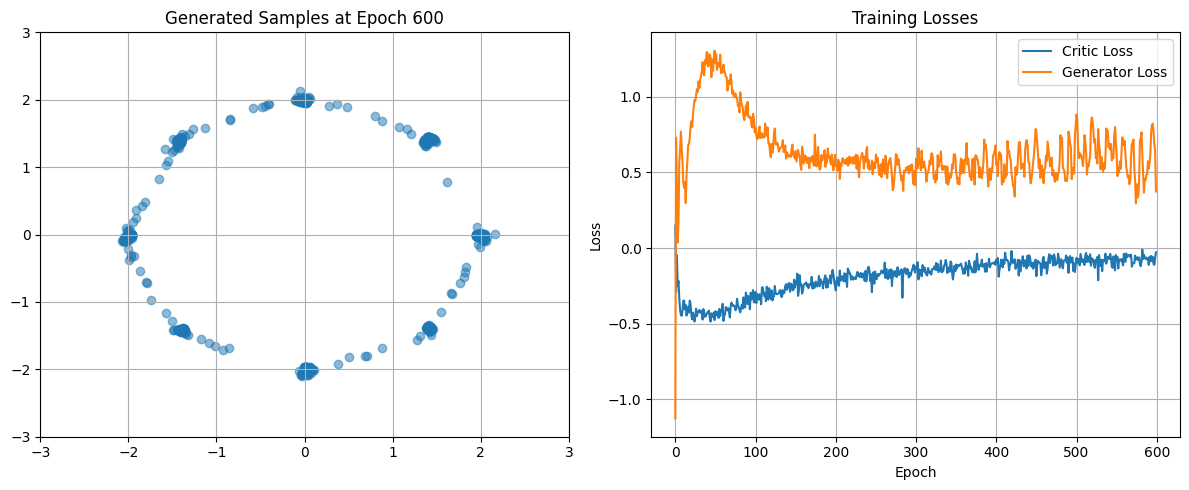

Epoch 0650/1000 | D Loss: -0.0950 | G Loss: 0.9325
Epoch 0700/1000 | D Loss: -0.0596 | G Loss: 0.6729


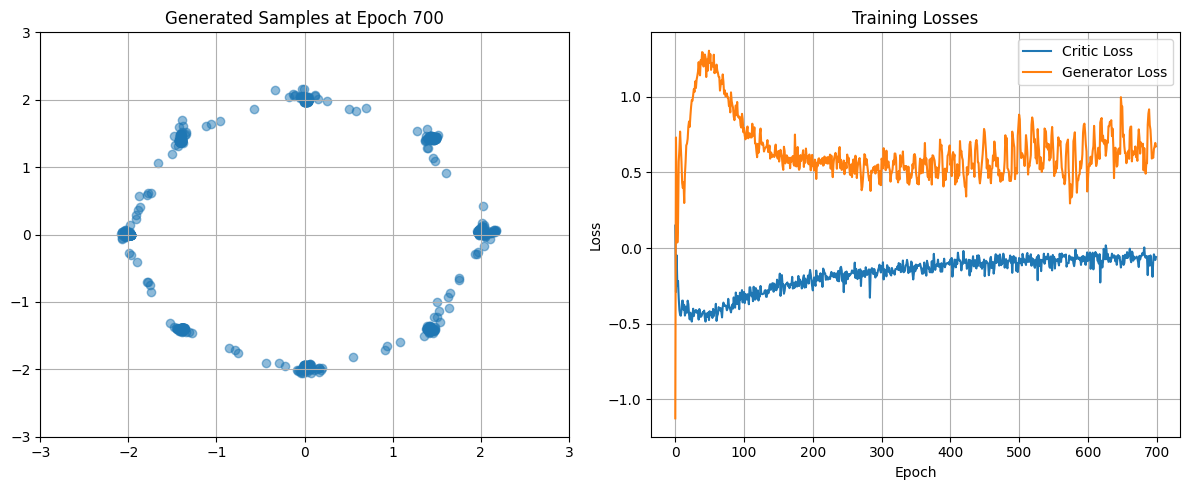

Epoch 0750/1000 | D Loss: -0.0812 | G Loss: 0.7654
Epoch 0800/1000 | D Loss: -0.0312 | G Loss: 0.5797


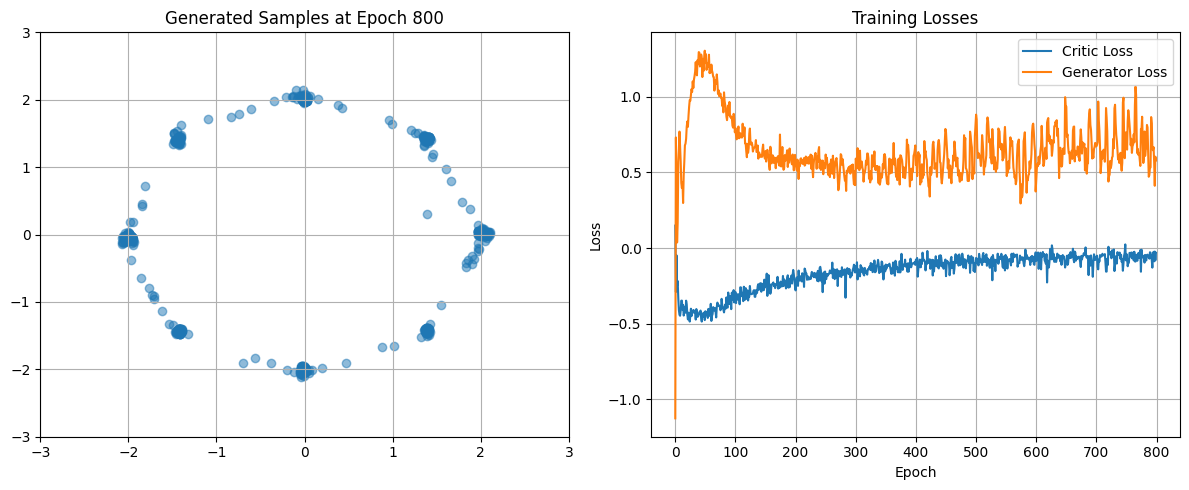

Epoch 0850/1000 | D Loss: -0.0314 | G Loss: 0.6826
Epoch 0900/1000 | D Loss: -0.0615 | G Loss: 0.7694


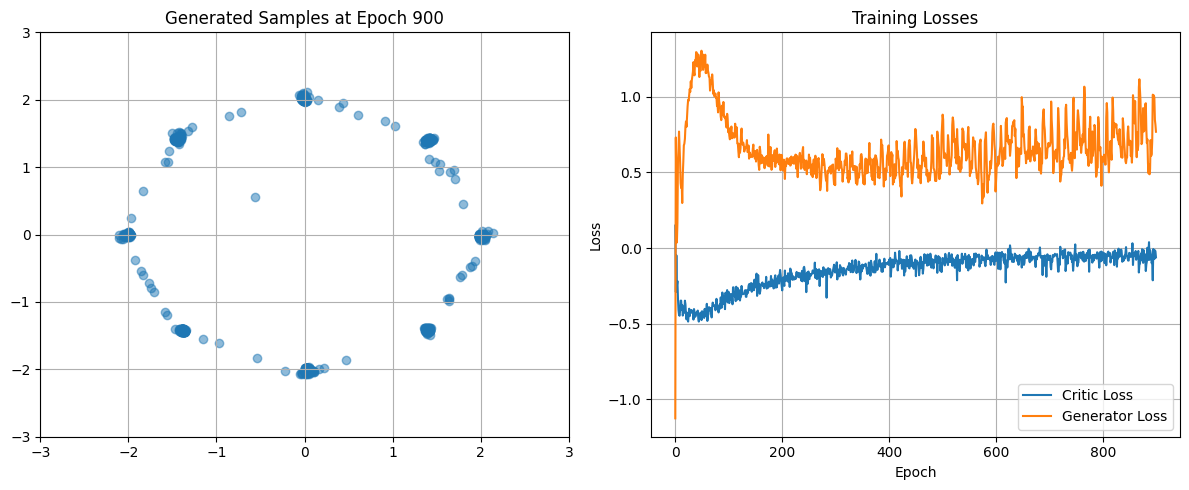

Epoch 0950/1000 | D Loss: -0.0847 | G Loss: 0.9322
Epoch 1000/1000 | D Loss: -0.0832 | G Loss: 0.6214


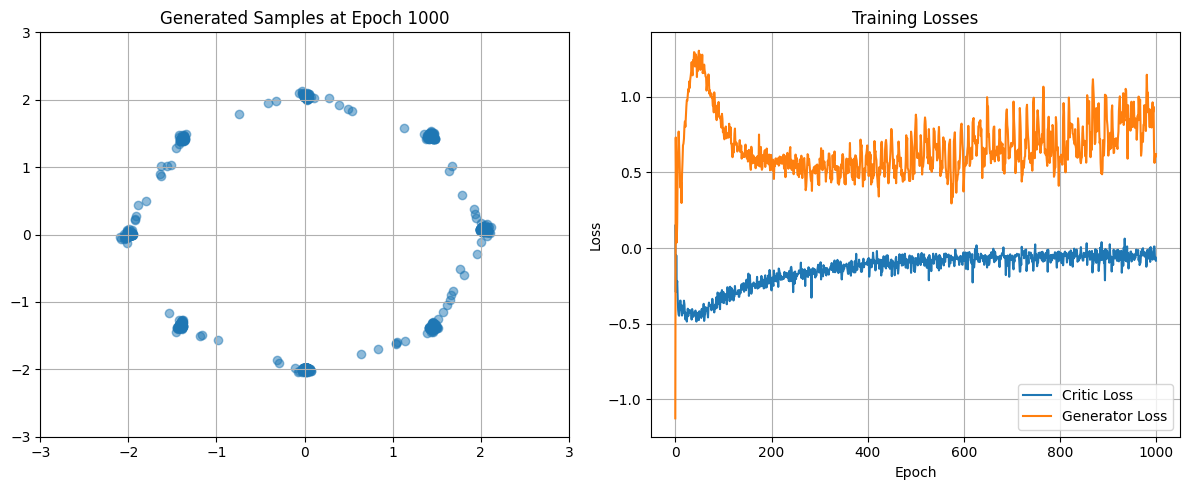

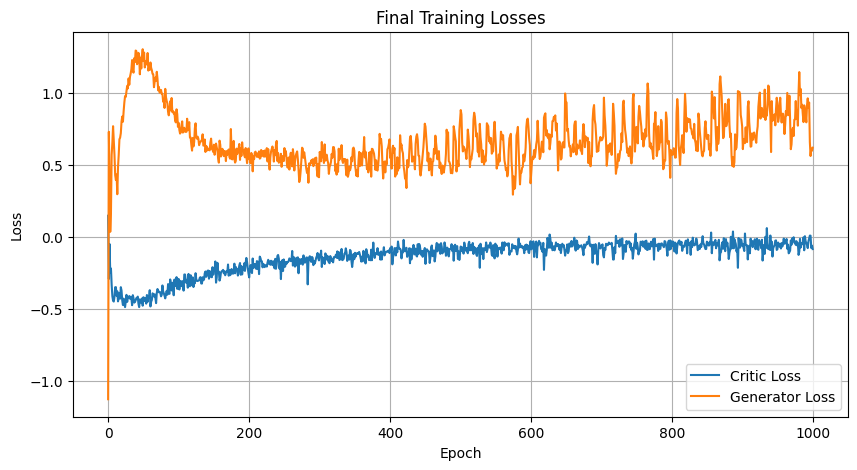

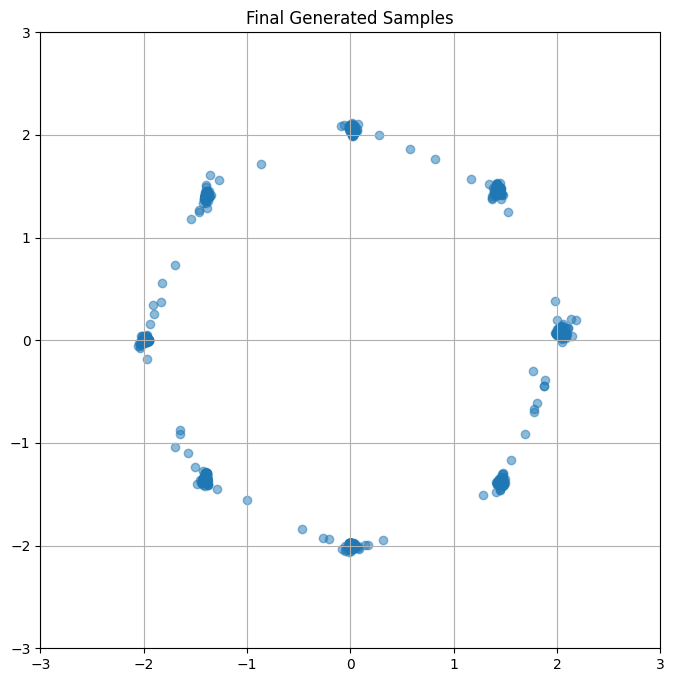

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = MLP_G().to(device)
D = MLP_D().to(device)

optimizer_G = optim.RMSprop(G.parameters(), lr=1e-4)
optimizer_D = optim.RMSprop(D.parameters(), lr=1e-4)

n_critic = 5
clip_value = 0.1
n_epochs = 1000

losses_G = []
losses_D = []


for epoch in range(n_epochs):
    for i, real_samples in enumerate(loader):
        real_samples = real_samples.to(device)
        batch_size = real_samples.size(0)

        # Train Critic
        for _ in range(n_critic):
            optimizer_D.zero_grad()
            
            # Real samples
            d_real = D(real_samples).mean()
            
            # Fake samples
            z = torch.randn(batch_size, 2).to(device)
            fake_samples = G(z).detach()
            d_fake = D(fake_samples).mean()
            
            # WGAN loss
            loss_D = -(d_real - d_fake)
            loss_D.backward()
            optimizer_D.step()
            
            # Clip weights
            for p in D.parameters():
                p.data.clamp_(-clip_value, clip_value)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, 2).to(device)
        gen_samples = G(z)
        loss_G = -D(gen_samples).mean()
        loss_G.backward()
        optimizer_G.step()

    # Record losses
    losses_D.append(loss_D.item())
    losses_G.append(loss_G.item())
    
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1:04d}/{n_epochs} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

    if (epoch+1) % 100 == 0 or epoch == 0:
        with torch.no_grad():
            z = torch.randn(1000, 2).to(device)
            samples = G(z).cpu().numpy()
            
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
            plt.xlim(-3, 3)
            plt.ylim(-3, 3)
            plt.title(f"Generated Samples at Epoch {epoch+1}")
            plt.grid(True)
            
            plt.subplot(1, 2, 2)
            plt.plot(losses_D, label='Critic Loss')
            plt.plot(losses_G, label='Generator Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Losses')
            plt.legend()
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()

# ====================== Final Visualization ======================
plt.figure(figsize=(10, 5))
plt.plot(losses_D, label='Critic Loss')
plt.plot(losses_G, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final Training Losses')
plt.legend()
plt.grid(True)
plt.show()

with torch.no_grad():
    z = torch.randn(1000, 2).to(device)
    samples = G(z).cpu().numpy()
    
    plt.figure(figsize=(8, 8))
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.title('Final Generated Samples')
    plt.grid(True)
    plt.show()

